In [1]:
import random
import re
import os
from punctuation_dict import get_punctuation_dict
from HMM_helper import *
from HMM import unsupervised_HMM
from syllable_dict import get_syllable_dict

from IPython.display import HTML

from HMM import unsupervised_HMM
from HMM_helper import (
    text_to_wordcloud,
    states_to_wordclouds,
    parse_observations,
    sample_sentence,
    visualize_sparsities,
    animate_emission
)

In [2]:
text = open(os.path.join(os.getcwd(), 'data/shakespeare.txt')).read()
syl_dict = get_syllable_dict()

In [3]:
#try learning by paragraph
def getData(text):
    lines = [line.split() for line in text.split('\n') if line.split()]
    cap_words = ["i'll", 'i', 'o']
    punc_dict = get_punctuation_dict()
    
    obs_counter = 0
    obs1 = []
    obs2 = []
    obs_map = {}
    obs_elem = [[],[],[],[]]
    #line_counter = 0
    for line in lines:
        if len(line) == 1:
            line_counter = 0
            obs1+= obs_elem[:-1]
            obs2.append(obs_elem[-1]) 
            obs_elem = [[],[],[],[]]
            continue
        #  4+4+4+2
        line_counter+=1
        
        for word in line:
            word = punc_dict[re.sub(r'[^\w]', '', word.lower())]
            #print(word)
            
            # Keep certain words capitalized
            if word in cap_words:
                word = word.capitalize()
            
            if word not in obs_map:
                # Add unique words to the observations map.
                obs_map[word] = obs_counter
                obs_counter += 1
                
            obs_elem[(line_counter-1)//4].append(obs_map[word])
            
        
    return obs1[3:],obs2[1:],obs_map


In [4]:
def parse_observations(text):
    # Convert text to dataset.
    lines = [line.split() for line in text.split('\n') if line.split()]

    # Store a list of words to keep capitalized
    cap_words = ['i', 'o']
    punc_dict = get_punctuation_dict()
    
    obs_counter = 0
    obs = []
    obs_map = {}

    # Iterate through all the lines of poems
    for line in lines:
        # Skip line with poem id (not an actual line of poem)
        if len(line) == 1:
            continue

        obs_elem = []
        
        for word in line:
            # Convert to lowercase and remove punctuations not part of a word
            word = punc_dict[re.sub(r'[^\w]', '', word.lower())]
            
            # Keep certain words capitalized
            if word in cap_words:
                word = word.capitalize()
            
            if word not in obs_map:
                # Add unique words to the observations map.
                obs_map[word] = obs_counter
                obs_counter += 1
            
            # Add the encoded word.
            obs_elem.append(obs_map[word])
        
        # Add the encoded sequence.
        obs_elem_r = obs_elem[::-1]
        obs.append(obs_elem_r)

    return obs, obs_map

In [5]:
def getRhymeDict(text):
    lines = [line.split() for line in text.split('\n') if line.split()]
    sonnets = []
    sonnet = []
    for line in lines:
        if len(line) == 1:
            # Only store sonnets with 14 lines
            if len(sonnet) == 14:
                sonnets.append(sonnet)
            sonnet = []
            continue
        sonnet.append(line)

    # This rhyme dictionary is a list of sets, where all the elements in each set rhyme with each other
    rhyme_dict = []
    punc_dict = get_punctuation_dict()
    cap_words = ["i'll", 'i', 'o']

    def process_word(word):
        '''
        This function takes as its input a word and returns the processed word by 
        getting rid of unnecessary punctuations / capitalizations. 
        ''' 
        # Exception "I'll" - confusion with ill should be manually taken care of
        if word == "I'll":
            return word 
        # Convert to lowercase and remove punctuations not part of a word
        word = punc_dict[re.sub(r'[^\w]', '', word.lower())]

        # Keep certain words capitalized
        if word in cap_words:
            word = word.capitalize()
        return word
    
    def add_to_rhyme_dict(w1, w2):
        group_contain_w1 = None
        group_contain_w2 = None
        for group in rhyme_dict:
            if w1 in group:
                group_contain_w1=group
                rhyme_dict.remove(group)
            continue
            if w2 in group:
                group_contain_w2=group
                rhyme_dict.remove(group)

        if not (group_contain_w1 or group_contain_w2):
            rhyme_dict.append({w1, w2})
        elif not group_contain_w1:
            group_contain_w2.add(w1)
            rhyme_dict.append(group_contain_w2)
        elif not group_contain_w2:
            group_contain_w1.add(w2)
            rhyme_dict.append(group_contain_w1)
        else:
            group_contain_w2.update(group_contain_w1)
            rhyme_dict.append(group_contain_w1)

    for sonnet in sonnets:
        # Get all the rhyming pairs in the first 3 stanzas
        for i in [0, 1, 4, 5, 8, 9]:
            word1 = process_word(sonnet[i][-1])
            word2 = process_word(sonnet[i+2][-1])
            add_to_rhyme_dict(word1, word2)
        # Last two rows of a sonnet rhyme
        add_to_rhyme_dict(process_word(sonnet[12][-1]), process_word(sonnet[13][-1]))
        
    rhyme_dict = [list(x) for x in rhyme_dict]
    return rhyme_dict

In [6]:
obs, obs_map = parse_observations(text)
hmm = unsupervised_HMM(obs, 5, 100)
#print(obs_map)

1
2
3
4
5
6
7
8
9
10
Iteration: 10
11
12
13
14
15
16
17
18
19
20
Iteration: 20
21
22
23
24
25
26
27
28
29
30
Iteration: 30
31
32
33
34
35
36
37
38
39
40
Iteration: 40
41
42
43
44
45
46
47
48
49
50
Iteration: 50
51
52
53
54
55
56
57
58
59
60
Iteration: 60
61
62
63
64
65
66
67
68
69
70
Iteration: 70
71
72
73
74
75
76
77
78
79
80
Iteration: 80
81
82
83
84
85
86
87
88
89
90
Iteration: 90
91
92
93
94
95
96
97
98
99
100
Iteration: 100


In [7]:
def geneSentence(hmm, obs_map,n_syl=10):
    # Get reverse map.
    obs_map_r = obs_map_reverser(obs_map)
    emission = hmm.generate_emission(n_syl,obs_map_r, syl_dict)[0]
    sentence = [obs_map_r[i] for i in emission][::-1]
    sentence[0] = sentence[0].capitalize()
    return ' '.join(sentence)

In [8]:
def geneSentence_rhyme(hmm, obs_map, start_word, n_syl=10):
    # Get reverse map.
    obs_map_r = obs_map_reverser(obs_map)
    start_state = hmm.find_state(obs_map[start_word])
    
    emission = hmm.generate_emission_with_start(n_syl,obs_map, obs_map_r,syl_dict,start_word, start_state)[0]
    sentence = [obs_map_r[i] for i in emission][::-1]
    sentence[0] = sentence[0].capitalize()
    return ' '.join(sentence)

In [9]:
def geneSonnet():
#need starting word num
    sonnet = ''
    
    for _ in range(12):
        s = geneSentence(hmm, obs_map)
        sonnet += (s + '\n')
    
    # Last stanza
    for _ in range(2):
        s = geneSentence(hmm, obs_map)
        sonnet += '  ' 
        sonnet += (s  + '\n')

    print(sonnet)

In [10]:
def geneSonnet_rhyme(ryhme_dict):
#need starting word num
    sonnet = ''
    ryhme_wordpair = []
    for _ in range(7):
        curr_group = random.choice(ryhme_dict)
        ryhme_wordpair.append(random.sample(curr_group, 2))
    print(ryhme_wordpair)
    
    for stanza in range(3):
        s1 = geneSentence_rhyme(hmm, obs_map, ryhme_wordpair[2*stanza][0])
        s3 = geneSentence_rhyme(hmm, obs_map, ryhme_wordpair[2*stanza][1])
        s2 = geneSentence_rhyme(hmm, obs_map, ryhme_wordpair[2*stanza+1][0])
        s4 = geneSentence_rhyme(hmm, obs_map, ryhme_wordpair[2*stanza+1][1])
        
        sonnet += (s1  + '\n' + s2 + '\n' + s3 + '\n' + s4 +'\n')
    
    # Last stanza
    s1 = geneSentence_rhyme(hmm, obs_map, ryhme_wordpair[-1][0])
    s2 = geneSentence_rhyme(hmm, obs_map, ryhme_wordpair[-1][1])
        
    sonnet += '  ' + s1 + '\n  ' + s2 + '\n' 
    print(sonnet)
    

In [11]:
ryhme_dict = getRhymeDict(text)
geneSonnet()
geneSonnet_rhyme(ryhme_dict)

Till witness wilful exceeds that thou since
So to seen to makes he honour shape or
Seal and like the nurseth than is thou and
Thee finding savage sake look by calls rite
Still keep to wrong have give this writ have this
Day the makes edge so why red aggravate
Make time my pain look in taker brave base
If every age growth that dost when she thou
After and too sing and winter so masked
Three-fold as hath self no bark and most her
That if thee would out-going within my
Are shame my flattery boast and I oaths if
  Parts let my hour than thine got come runs the
  Farther to earth needs change not rich hate so

[['incertainty', 'tyranny'], ["fleet'st", 'sweets'], ['sits', 'commits'], ['depends', 'amends'], ['deserts', 'parts'], ['decayed', 'aid'], ['costs', 'boast']]
Cheeks to certain foot head incertainty
Thou brand am perpetual my dancing fleet'st
Say sharp'st others sleep creatures tyranny
Date ill five and remote lines she or sweets
What my nor bitter third my shalt to sits
Sweet when my

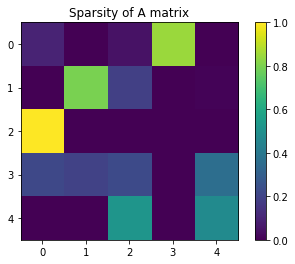

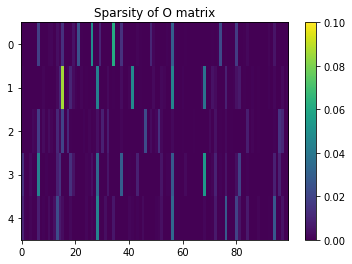

In [14]:
visualize_sparsities(hmm, O_max_cols=100)

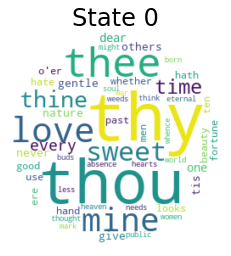

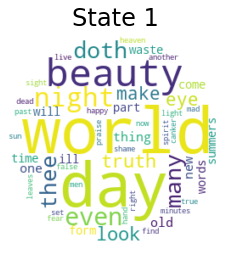

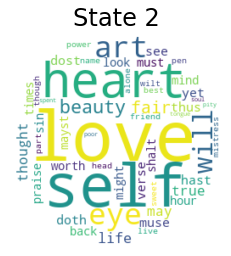

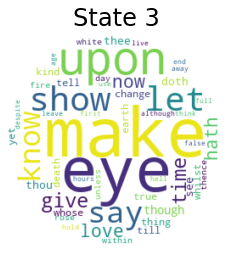

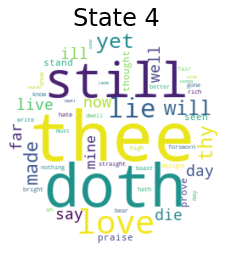

In [13]:
obs_map_r = obs_map_reverser(obs_map)
wordclouds = states_to_wordclouds(hmm, obs_map, obs_map_r, syl_dict)